In [1]:
%%HTML
<style> div.output {flex-direction: row} div.output > div:only-child {width: 100%} </style>

In [2]:
import numpy
numpy.set_printoptions(linewidth=numpy.nan)

<img style="margin-left: auto; margin-right: auto; width: 50%" src="uproot-3.png"></img>

What's new?

   * more modularization
   * writing files
   * jagged array operations

## More modularization

uproot 2 had been a single library (optionally depending on lz4).

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers-before.png"></img>

## More modularization

uproot 3 splits out everything that is not I/O. We'll see the advantage in a moment.

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers.png"></img>

## Writing files

uproot can now write histograms to files. It has the same dict-like interface as reading:

In [3]:
import uproot
import numpy

f = uproot.recreate("tmp.root")                                  # instead of uproot.open
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000))   # any kind of histogram

In [4]:
f["name"].show()                                                 # read it back out

                          0                                                33450
                          +----------------------------------------------------+
[-inf, -4.4287)     0     |                                                    |
[-4.4287, -3.5993)  15    |                                                    |
[-3.5993, -2.7699)  261   |                                                    |
[-2.7699, -1.9405)  2347  |****                                                |
[-1.9405, -1.1111)  10769 |*****************                                   |
[-1.1111, -0.28175) 25490 |****************************************            |
[-0.28175, 0.54765) 31857 |**************************************************  |
[0.54765, 1.377)    20796 |********************************                    |
[1.377, 2.2064)     7130  |***********                                         |
[2.2064, 3.0358)    1244  |**                                                  |
[3.0358, 3.8652)    91    | 

In [5]:
import ROOT
c = ROOT.TCanvas()

Welcome to JupyROOT 6.14/04


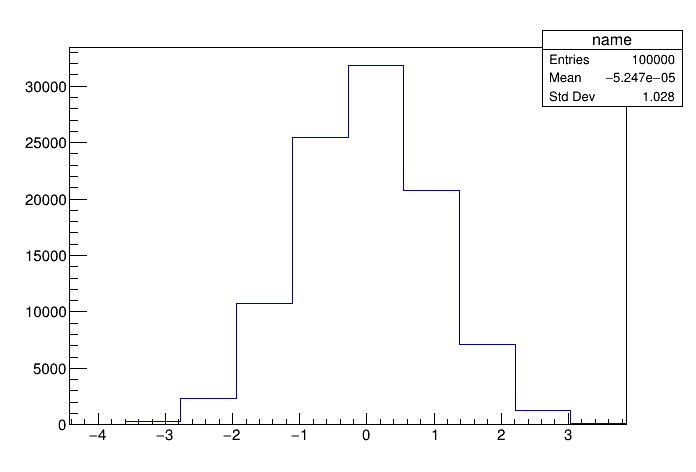

In [6]:
f = ROOT.TFile("tmp.root")                    # ROOT can read it, too
h = f.Get("name")
h.Draw()
c.Draw()

In [7]:
f = ROOT.TFile("tmp.root", "UPDATE")          # ROOT can add to the same file, too
h = ROOT.TH1D("another", "", 10, -5, 5)
for x in numpy.random.normal(0, 1, 100000):
    h.Fill(x)
h.Write()
f.Close()

In [8]:
f = uproot.open("tmp.root")
f["another"].show()

                 0                                                         35889
                 +-------------------------------------------------------------+
[-inf, -5) 0     |                                                             |
[-5, -4)   7     |                                                             |
[-4, -3)   141   |                                                             |
[-3, -2)   2152  |****                                                         |
[-2, -1)   13667 |***********************                                      |
[-1, 0)    33879 |**********************************************************   |
[0, 1)     34180 |**********************************************************   |
[1, 2)     13693 |***********************                                      |
[2, 3)     2141  |****                                                         |
[3, 4)     137   |                                                             |
[4, 5)     3     |          

uproot could become a clearinghouse for histograms from different libraries.

In [9]:
%matplotlib inline
import physt                    # https://physt.readthedocs.io

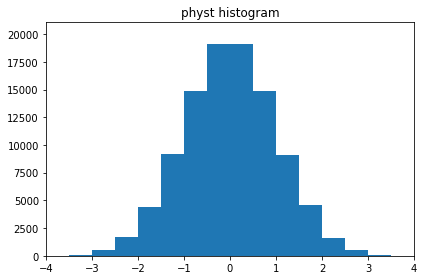

In [10]:
h = physt.h1(numpy.random.normal(0, 1, 100000),
             bins=16, range=(-4, 4), name="physt histogram")
h.plot();

In [11]:
f = uproot.recreate("tmp.root")   # save it as a TH1D
f["name"] = h

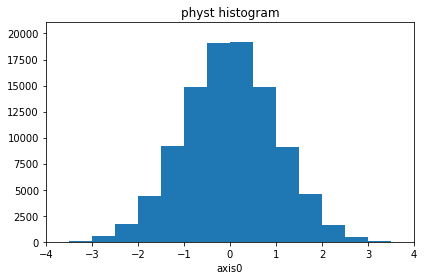

In [12]:
f = uproot.open("tmp.root")       # read it back and convert it back to physt
f["name"].physt().plot();

In [13]:
f["name"].numpy()                  # or numpy

(array([   16,   110,   562,  1725,  4430,  9198, 14908, 19103, 19147, 14904,  9115,  4554,  1610,   492,   103,    17], dtype=int32),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]))

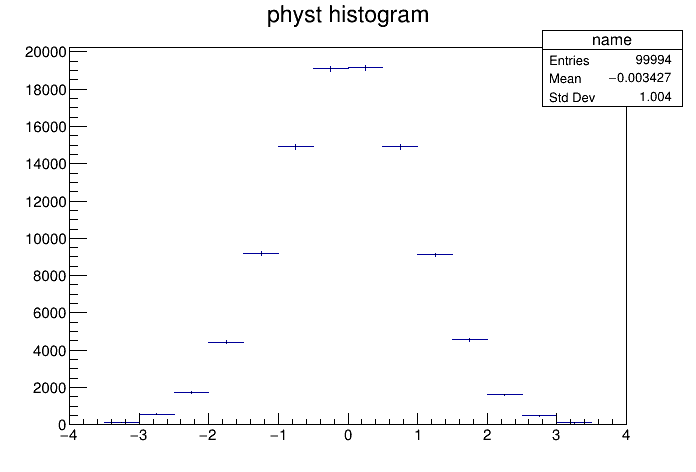

In [14]:
f = ROOT.TFile("tmp.root")         # but look, it's really ROOT
h = f.Get("name")
h.Draw()
c.Draw()

This can also include new ways of looking at histograms.

In [15]:
f = uproot.open("tmp.root")
print(f["name"].hepdata())      # YAML format for the HEPData archival site

dependent_variables:
- header: {name: counts, units: null}
  qualifiers: []
  values:
  - errors:
    - {label: stat, symerror: 4.0}
    value: 16.0
  - errors:
    - {label: stat, symerror: 10.488088481701515}
    value: 110.0
  - errors:
    - {label: stat, symerror: 23.706539182259394}
    value: 562.0
  - errors:
    - {label: stat, symerror: 41.53311931459037}
    value: 1725.0
  - errors:
    - {label: stat, symerror: 66.55824516917495}
    value: 4430.0
  - errors:
    - {label: stat, symerror: 95.90620417887469}
    value: 9198.0
  - errors:
    - {label: stat, symerror: 122.09832103677756}
    value: 14908.0
  - errors:
    - {label: stat, symerror: 138.21360280377615}
    value: 19103.0
  - errors:
    - {label: stat, symerror: 138.3726851658231}
    value: 19147.0
  - errors:
    - {label: stat, symerror: 122.08193969625482}
    value: 14904.0
  - errors:
    - {label: stat, symerror: 95.4725091322104}
    value: 9115.0
  - errors:
    - {label: stat, symerror: 67.4833312752

This includes an idea I've been working on in which Pandas DataFrames with an interval index _are_ histograms.

In [16]:
f = uproot.open("tmp.root")         # read as histogram
h = f["name"].pandas()
h

,count,variance
physt histogram,,
"[-inf, -4.0)",2,0.0
"[-4.0, -3.5)",16,16.0
"[-3.5, -3.0)",110,110.0
"[-3.0, -2.5)",562,562.0
"[-2.5, -2.0)",1725,1725.0
"[-2.0, -1.5)",4430,4430.0
"[-1.5, -1.0)",9198,9198.0
"[-1.0, -0.5)",14908,14908.0
"[-0.5, 0.0)",19103,19103.0


In [17]:
f = uproot.recreate("tmp.root")     # write as histogram
f["another"] = h

Given the way Pandas handles indexes (interval indexes in particular), Pandas-as-histograms are sparse histograms.

In [18]:
f = uproot.recreate("tmp.root")
f["one"]   = numpy.histogram(numpy.random.normal(1, 0.6, 10000), bins=8, range=(0, 8))
f["two"]   = numpy.histogram(numpy.random.normal(3, 0.4, 10000), bins=8, range=(0, 8))
f["three"] = numpy.histogram(numpy.random.normal(9, 0.6, 100000), bins=8, range=(0, 8))
one   = f["one"].pandas()
two   = f["two"].pandas()
three = f["three"].pandas()

In [19]:
from IPython.display import display
display(one); display(two); display(three);

,count,variance
"[0.0, 1.0)",4507,4507
"[1.0, 2.0)",4564,4564
"[2.0, 3.0)",444,444
"[3.0, 4.0)",3,3


,count,variance
"[1.0, 2.0)",69,69
"[2.0, 3.0)",4900,4900
"[3.0, 4.0)",4965,4965
"[4.0, 5.0)",66,66


,count,variance
"[6.0, 7.0)",50,50
"[7.0, 8.0)",4795,4795


Adding DataFrames matches up intervals and fills in missing values with NaN (0 if we explicitly set it).

In [20]:
import functools
def add(*args):
    return functools.reduce(lambda x, y: x.add(y, fill_value=0), args)

display(add(one, two)); display(add(two, three)); display(add(one, two, three))

,count,variance
"[0.0, 1.0)",4507.0,4507.0
"[1.0, 2.0)",4633.0,4633.0
"[2.0, 3.0)",5344.0,5344.0
"[3.0, 4.0)",4968.0,4968.0
"[4.0, 5.0)",66.0,66.0


,count,variance
"[1.0, 2.0)",69.0,69.0
"[2.0, 3.0)",4900.0,4900.0
"[3.0, 4.0)",4965.0,4965.0
"[4.0, 5.0)",66.0,66.0
"[6.0, 7.0)",50.0,50.0
"[7.0, 8.0)",4795.0,4795.0


,count,variance
"[0.0, 1.0)",4507.0,4507.0
"[1.0, 2.0)",4633.0,4633.0
"[2.0, 3.0)",5344.0,5344.0
"[3.0, 4.0)",4968.0,4968.0
"[4.0, 5.0)",66.0,66.0
"[6.0, 7.0)",50.0,50.0
"[7.0, 8.0)",4795.0,4795.0


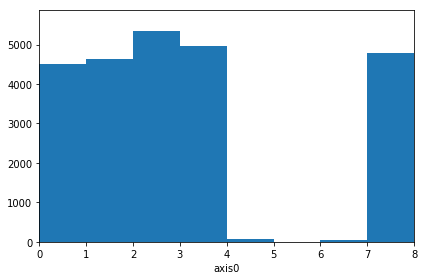

In [21]:
f["all"] = add(one, two, three)
f["all"].physt().plot();

## Modularized file-writing and histogram-conversion

   * all of the histogram-writing code (bytes in file) is in **uproot**
   * all of the code that recognizes different histogram libraries and converts them is in **uproot-methods**

**uproot-methods** can be updated independently of (more rapidly than) **uproot**.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

<img style="float: right; width: 40%" src="pratyush.jpg"></img>

## Credit

This feature was developed by Pratyush Das, a DIANA-HEP undergraduate fellow.

(Most of the work was writing _anything_ to a ROOT file; histograms were the last week!)

## Jagged array operations

Also originally part of uproot, split out into **awkward-array** to be generalized and applied beyond ROOT.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

Jagged arrays are a minimal unit of nested structure: a list containing lists of varying lengths.

In [22]:
f = uproot.open("HZZ-objects.root")
t = f["events"]

In [23]:
a = t.array("muoniso")
a

<JaggedArray [[4.2001534 2.1510613] [2.1880474] [1.4128217 3.3835042] ... [3.7629452], [0.5508107], [0.]] at 7f73e7ca7320>

The implementation is a façade: these are not millions of list objects in memory but two arrays with methods to make them _behave like_ nested lists.

In [24]:
a.offsets

array([   0,    2,    3, ..., 3823, 3824, 3825])

In [25]:
a.content

array([4.2001534, 2.1510613, 2.1880474, ..., 3.7629452, 0.5508107, 0.       ], dtype=float32)

In [26]:
for i, x in enumerate(a):
    if i == 20:
        break
    print(i, x)

0 [4.2001534 2.1510613]
1 [2.1880474]
2 [1.4128217 3.3835042]
3 [2.7284882 0.5522966]
4 [0.        0.8563976]
5 [0.        1.4929442]
6 [0.6231756 0.       ]
7 [2.4025257]
8 [0. 0.]
9 [0.        1.7698176]
10 [2.0015755 0.6041591]
11 [0.         0.76338214]
12 [1.7191544]
13 [0.]
14 [0.6410858 1.2613294]
15 [0.        2.0141196]
16 [0.88719386 1.5272698 ]
17 [5.685393]
18 [0.76651436 0.        ]
19 [1.1567837 2.0942292 0.6321085]


Introducing additional types, like "table" as a struct of arrays presented as an array of structs, allows us to make tables of jagged arrays or jagged arrays of tables.

In [27]:
a = t.array("muonp4")
a

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7f73e7ce87f0>

In [28]:
a.content.content

<Table [<TLorentzVector 0> <TLorentzVector 1> <TLorentzVector 2> ... <TLorentzVector 3822>, <TLorentzVector 3823>, <TLorentzVector 3824>] at 7f73e7d10f28>

In [29]:
a.columns

['fX', 'fY', 'fZ', 'fE']